In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
options(repr.plot.width=10, repr.plot.height=8)

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv")

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1)

drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor"))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Figure 1
## Figure 1a

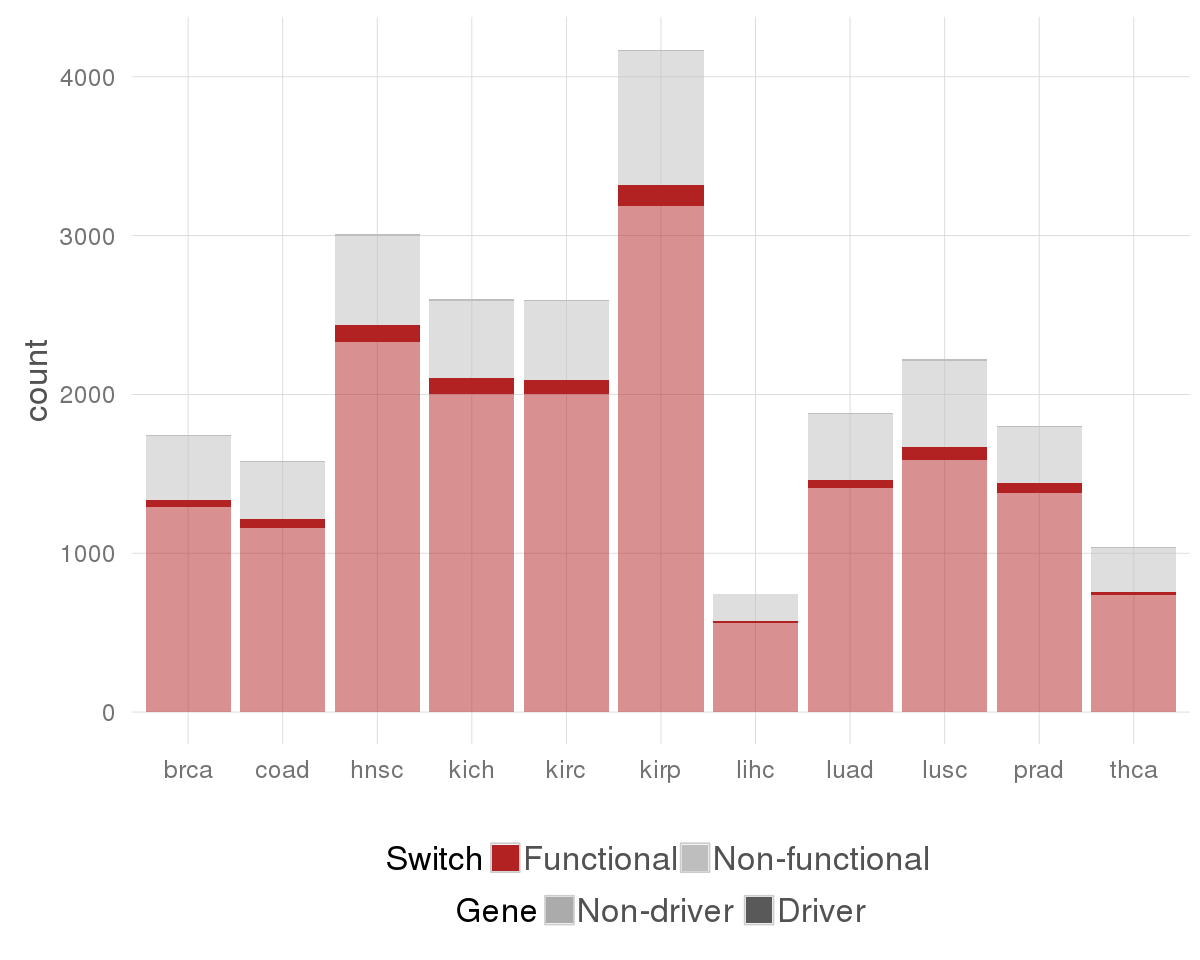

In [2]:
switches.split  %>%
    filter(NotNoise==1 & IsModel==1) %>%
    mutate(Driver = ifelse(Symbol %in% drivers$Symbol, "1", "0"),
           Driver = revalue(Driver, c("1"="Driver", "0"="Non-driver")),
           Driver = factor(Driver, levels=c("Non-driver","Driver")),
           IsFunctional = revalue(as.character(IsFunctional), c("1"="Functional", "0"="Non-functional"))) %>%
    ggplot(aes(x=Tumor, fill=IsFunctional, alpha=Driver)) +
        geom_bar() +
        labs(x="", fill="Switch", alpha="Gene") +
        scale_fill_manual(values=c("Functional"="firebrick", "Non-functional"="gray")) +
        scale_alpha_manual(values=c("Driver"=1, "Non-driver"=0.5)) +
        smartas_theme() +
        theme(legend.position="bottom")

Number of switches (y axis) calculated in each tumor type (x axis), separated according to whether the switches are functional or not.
## Figure 1b

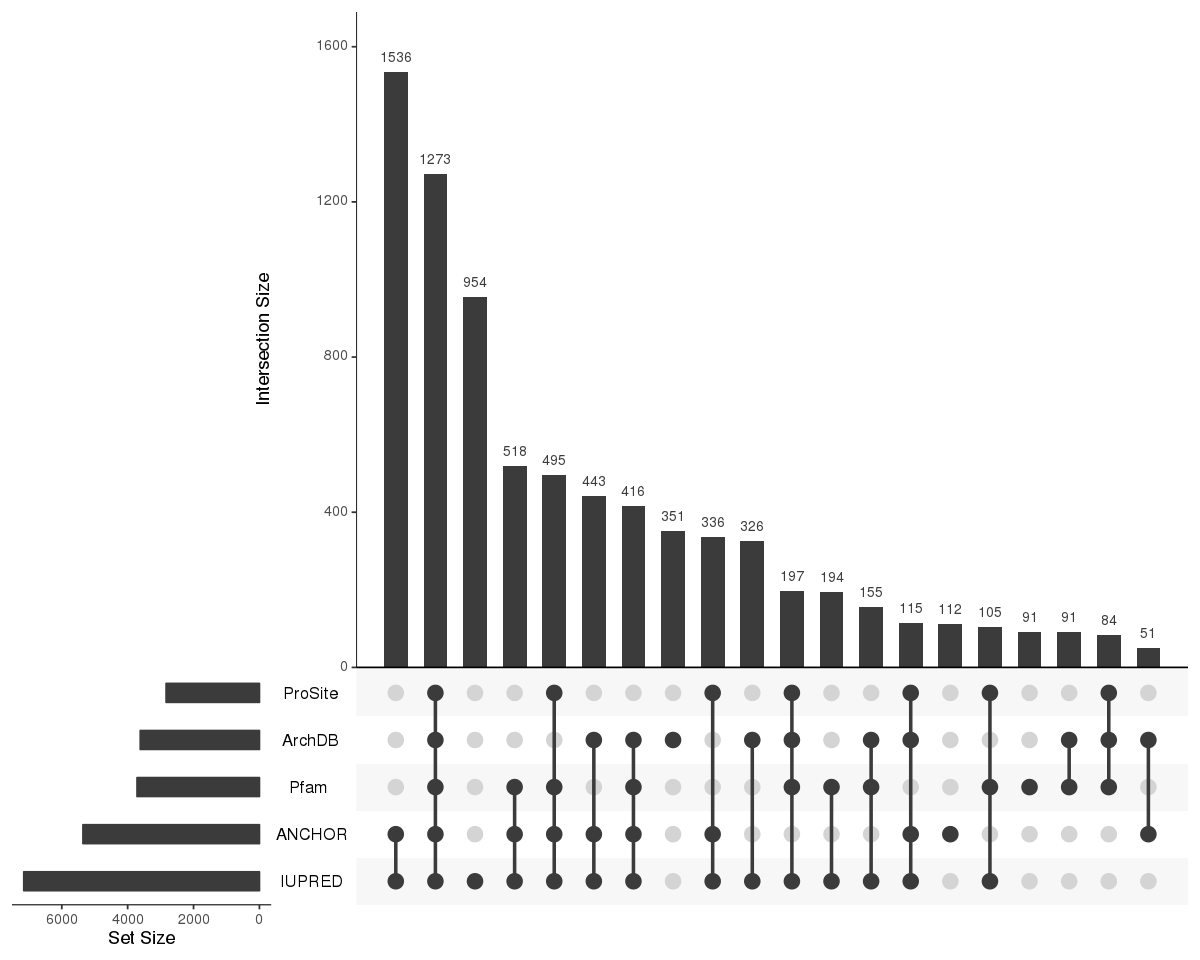

In [3]:
library(UpSetR)

structural <- lapply(cancerTypes, function(tumor){
    paste0("../data/structural_analysis/",tumor,".structural_summary.tsv") %>%
    read_tsv %>%
    set_colnames(c('GeneId','Symbol','Normal_transcript','Tumor_transcript',
                   'ArchDB','Pfam','IUPRED','ANCHOR','ProSite')) %>%
    mutate(ArchDB = ifelse(ArchDB=="True",1,0),
           Pfam = ifelse(Pfam=="True",1,0),
           IUPRED = ifelse(IUPRED=="True",1,0),
           ANCHOR = ifelse(ANCHOR=="True",1,0),
           ProSite = ifelse(ProSite=="True",1,0))
}) %>% do.call("rbind",.) %>%
    unique %>%
    merge(switches)

structural %>%
    select(ArchDB,Pfam,IUPRED,ANCHOR,ProSite) %>%
    # top 20 intersections
    upset(order.by = "freq", nintersects = 20,)

Overlap graph of protein features affected in functional switches.
## Figure 1c


Attaching package: ‘scales’

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric



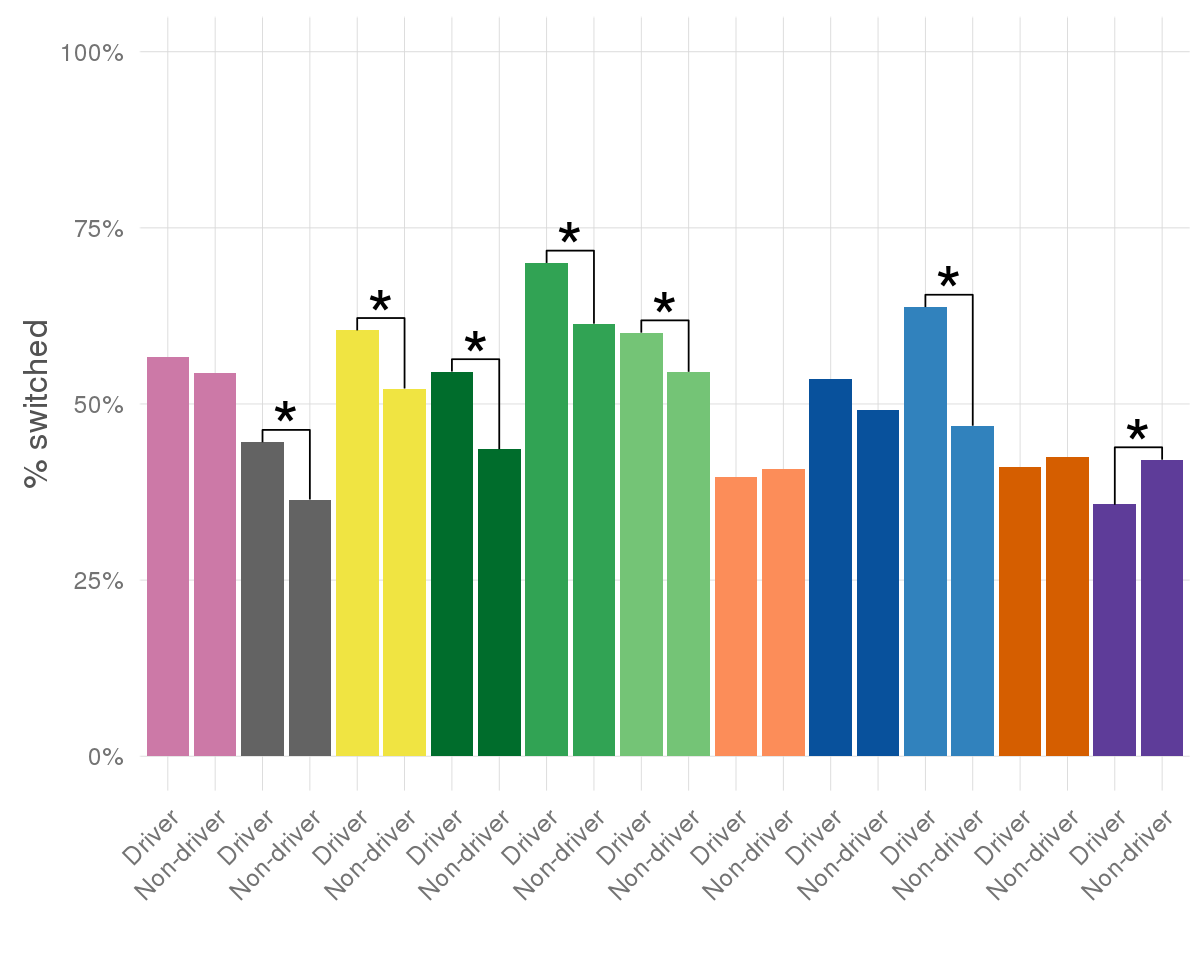

In [4]:
library(scales)
library(ggstars)

proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    set_colnames(c("Tumor","GeneId","Symbol","Transcript","TPM","ProteinLength","asEvidence")) %>%
    filter(asEvidence=="True")

proteome.drivers <- proteome %>%
    mutate(Driver = as.numeric(Symbol %in% drivers$Symbol) ) %>%
    select(Tumor,GeneId, Driver)
    
proteome.switches <- proteome %>%
    merge(switches.split %>% filter(IsFunctional==1)) %>%
    select(Tumor,GeneId) %>%
    mutate(Switch=1)

driver.enrichment <- proteome %>%
    merge(proteome.drivers, all.x=T) %>%
    merge(proteome.switches, all.x=T) %>%
    mutate(Driver = ifelse(is.na(Driver), 0, Driver),
           Switch = ifelse(is.na(Switch), 0, Switch)) %>%
    group_by(Tumor) %>%
    summarise(SwDr = sum(Driver==1 & Switch==1),
              NSwDr = sum(Driver==1 & Switch==0),
              SwNDr = sum(Driver==0 & Switch==1),
              NSwNDr = sum(Driver==0 & Switch==0))

driver.enrichment <- apply(driver.enrichment[,2:5],1,function(x){
    f <- fisher.test(matrix(x,2,2))
    p <- f$p.value
    OR <- as.numeric(f$estimate)
    c(p=p,OR=OR)
}) %>% t%>% as.data.frame %>%
    cbind(driver.enrichment,.)

driver.enrichment.melt <- driver.enrichment %>%
    select(-p, -OR) %>%
    melt(id.vars="Tumor") %>%
    mutate( Driver = ifelse(variable %in% c("SwDr","NSwDr"), "Driver", "Non-driver"),
            Switch = ifelse(variable %in% c("SwDr","SwNDr"), "Switch", "No switch"),
            Tag = paste(Tumor, Driver, sep="_"))

axisLabels <- strsplit(driver.enrichment.melt$Tag, "_") %>% unlist %>% .[c(F,T)]
names(axisLabels) <- driver.enrichment.melt$Tag

p <- ggplot(driver.enrichment.melt , aes(x=Tag, y=value, fill=Tumor, alpha=Switch)) +
    geom_bar(stat="identity",position="fill") +
    labs(x="", y="% switched") +
    smartas_theme() +
    scale_fill_manual(values=colorPalette) +
    scale_alpha_manual(values=c("Switch"=1, "No switch"=0)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=axisLabels) +
    scale_y_continuous(labels = percent)

star_bar(p, driver.enrichment$p < 0.05)

save(p,driver.enrichment,axisLabels,driver.enrichment.melt,file="~/ggstars/data/bar.rda")

Mutational cancer drivers (Methods) with multiple transcript isoforms show enrichment of functional switches compared to other genes with similar characteristics.
## Figure 1d

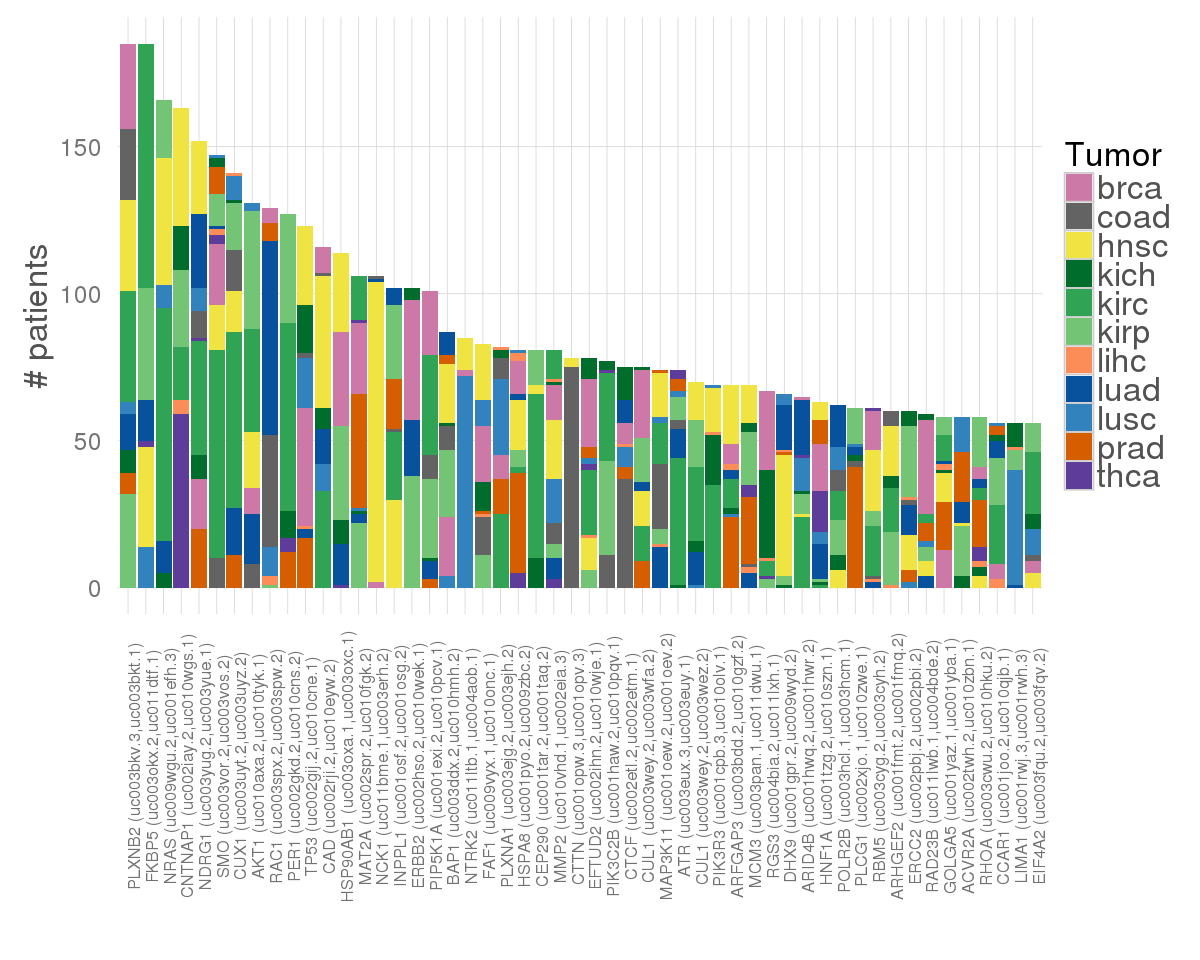

In [5]:
top50.drivers <- switches %>%
    filter(Symbol %in% drivers$Symbol & IsFunctional==1) %>%
    arrange(desc(PatientNumber)) %>%
    top_n(50, PatientNumber) %>%
    mutate(label = paste0(Symbol," (",Normal_transcript,",",Tumor_transcript,")")) %>%
    select(Normal_transcript,Tumor_transcript,label)

merge(top50.drivers, switches.split) %>%
    mutate(label = factor(label, levels=top50.drivers$label)) %>%
    ggplot(aes(x=label, y=PatientNumber, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="# patients") +
        scale_fill_manual(values=colorPalette) +
        smartas_theme() +
        theme(legend.position="right", axis.text.x = element_text(angle = 90, size=10))

Top 50 functional switches in mutational cancer drivers according to the number of patients in which they occur. We indicate in color the tumor type. 
# Figure 2
## Figure 2a

Warning message:
: Removed 164 rows containing missing values (geom_point).

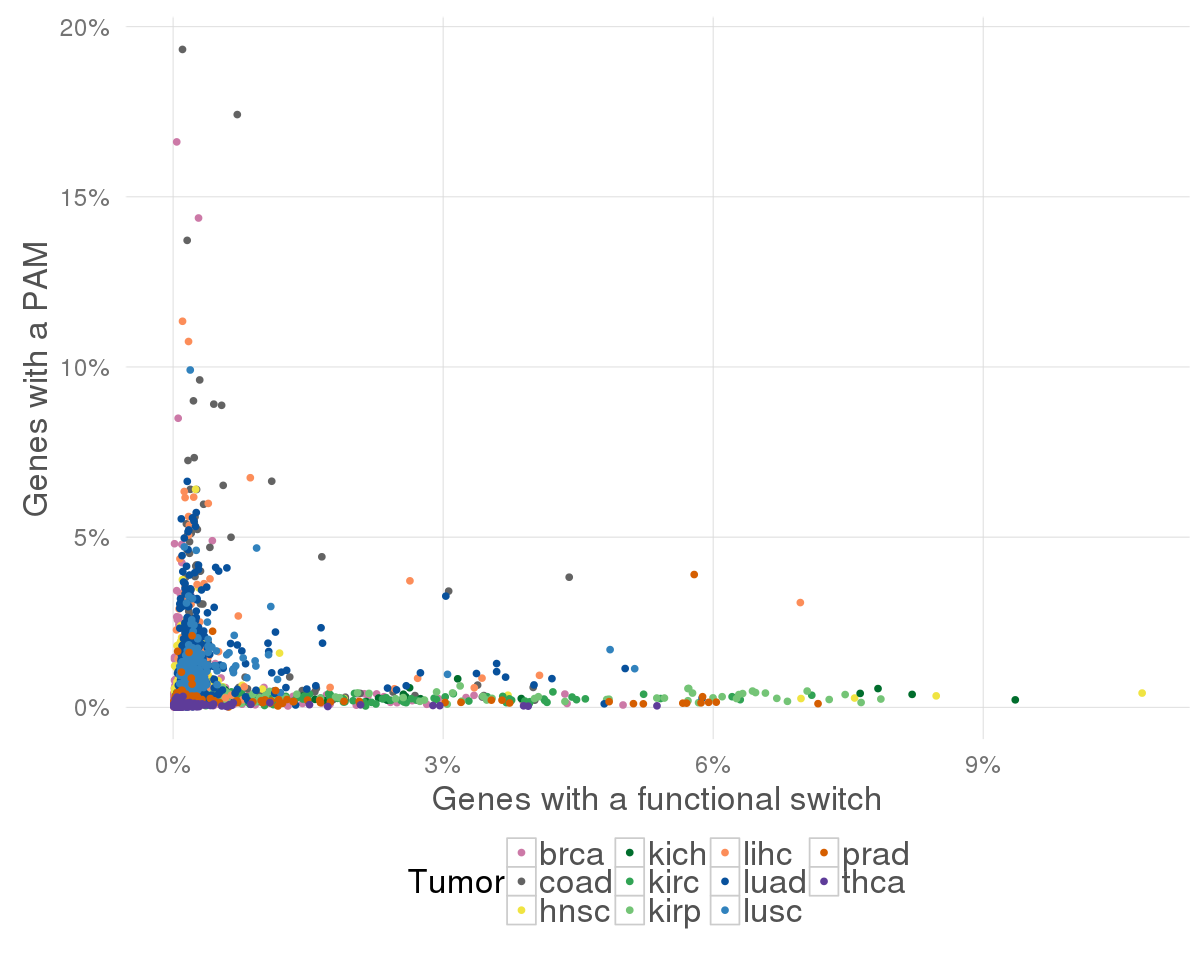

In [6]:
# read mutations
wes <- read_tsv("../data/mutations/wes_mutations.txt") %>%
    select(Tumor,Gene,Symbol,Patient) %>%
    unique

# count number of genes altered per patient
## WES mutation
genesPAM.perPatient <- wes %>%
    group_by(Tumor,Patient) %>%
    summarise(PAM=length(Patient))

## a functional switch
genesSwitched.perPatient <- switches$Patients_affected[switches$IsFunctional==1] %>%
    strsplit(",") %>% unlist %>%
    table %>% as.data.frame %>%
    set_colnames(c("Patient","Switch"))

# use number of spliced genes and total number of genes to normalize the observations
lines <- "Tumor\tSplicedGenes\tGenes\nbrca\t12383\t20530\nprad\t11849\t20530\nthca\t11812\t20530\ncoad\t11498\t20530\nhnsc\t11583\t20530\nkich\t11607\t20530\nkirc\t12205\t20530\nkirp\t11853\t20530\nlihc\t10490\t20530\nluad\t12046\t20530\nlusc\t12070\t20530\n"
consideredGenes <- read_tsv(lines) %>%
    set_colnames(c("Tumor","SplicedGenes","Genes"))

recurrence <- merge(genesSwitched.perPatient,genesPAM.perPatient,all=T) %>%
    merge(consideredGenes) %>%
    mutate(PAM=PAM/Genes, Switch=Switch/SplicedGenes) %>%
    select(everything(),-contains("Genes"))

# show lack of correlation between mutations and switches
recurrence %>%
    ggplot(aes(x=Switch,y=PAM)) + 
        geom_point(aes(color=Tumor)) + 
        smartas_theme() +
        scale_color_manual(values=colorPalette) + 
        theme(legend.position="bottom") +
        labs(x="Genes with a functional switch", y="Genes with a PAM") +
        scale_y_continuous(labels = percent) +
        scale_x_continuous(labels = percent)

For each patient sample, colored according to tumor type, we indicate the proportion of all genes with protein affecting mutations (PAMs) in the sample (y axis), and the proportion of genes with multiple transcript isoforms that present a functional isoform switch in the same sample (x axis).
## Figure 2b

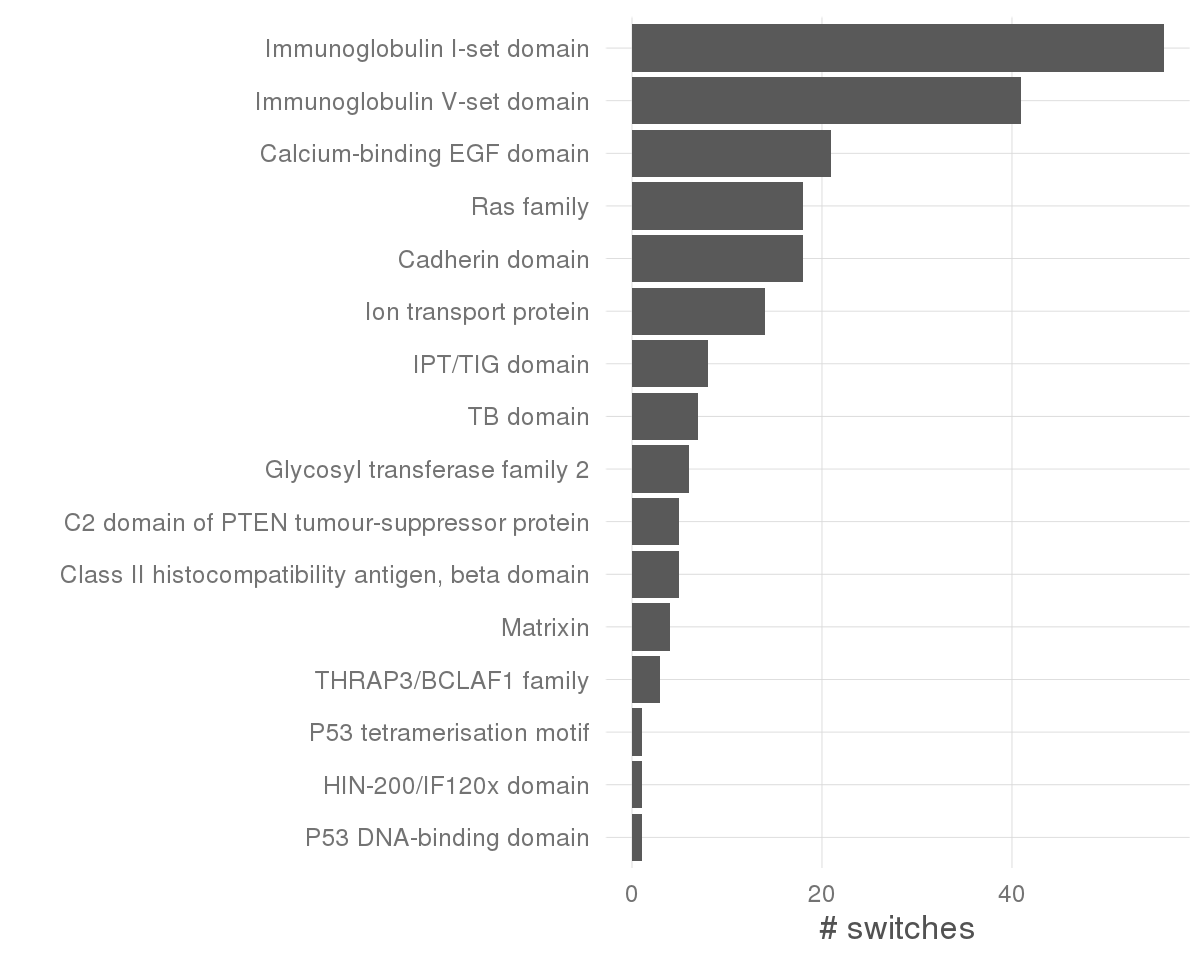

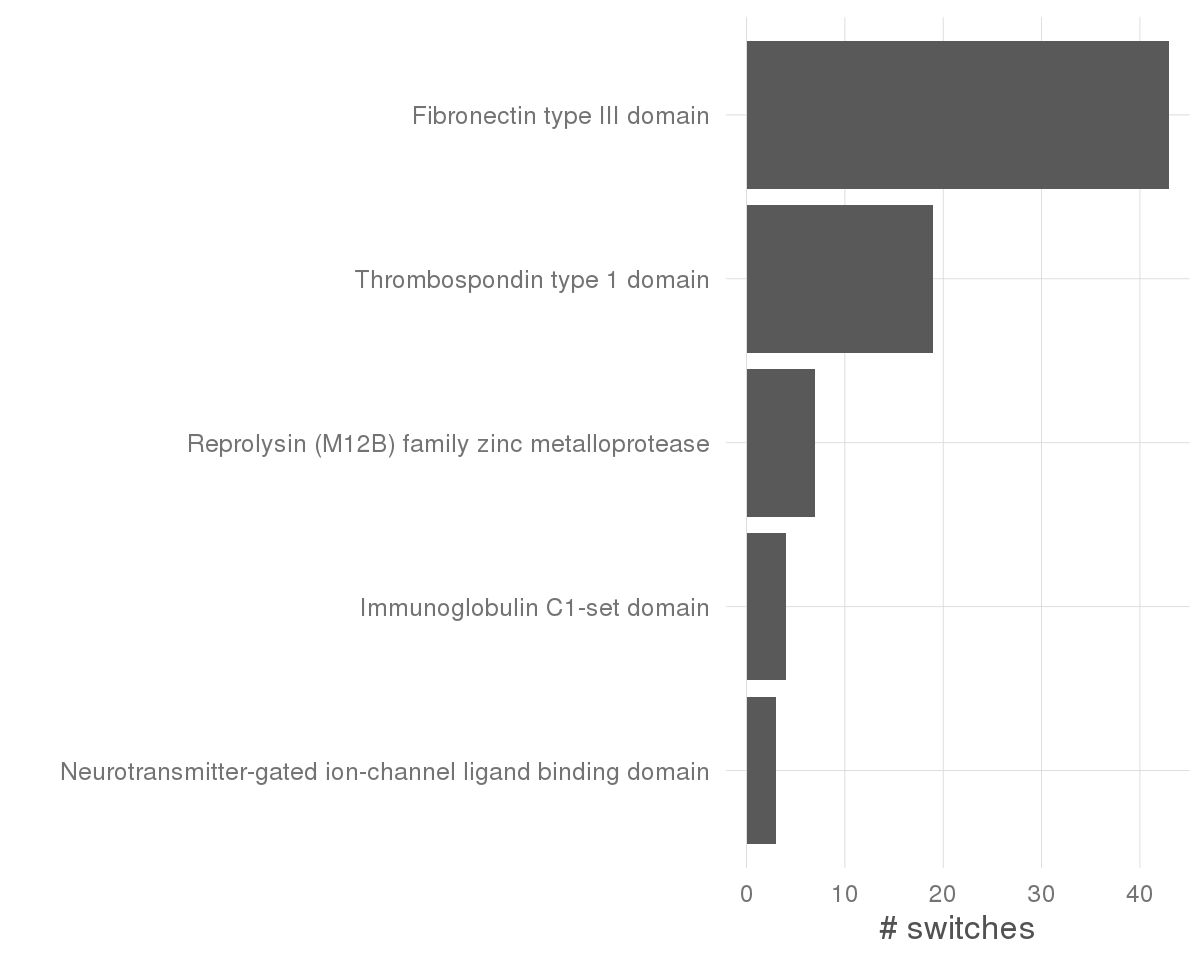

In [7]:
MS.pfams <- read_tsv("../results/pfam_enrichment_analysis.tsv") %>%
    filter((adjp_g < 0.05 | adjp_l < 0.05) & adjp_m < 0.05) %>%
    select(Feature, switches_g, switches_l) %>%
    mutate(Feature = unlist(strsplit(Feature,"|", fixed=T))[c(F,T)],
           Feature = gsub("_"," ",Feature)) 

MS.pfams %>%
    filter(switches_l > 0) %>%
    arrange(switches_l) %>%
    mutate( Feature = factor(Feature, levels=Feature)) %>%
    ggplot(aes(x=Feature, y=switches_l)) +
        geom_bar(stat="identity") +
        labs(y="# switches", x="") +
        smartas_theme() +
        coord_flip()

MS.pfams %>%
    filter(switches_g > 0) %>%
    arrange(switches_g) %>%
    mutate( Feature = factor(Feature, levels=Feature)) %>%
    ggplot(aes(x=Feature, y=switches_g)) +
        geom_bar(stat="identity") +
        labs(y="# switches", x="") +
        smartas_theme() +
        coord_flip()

Domain classes that are are enriched in losses (left panel) or gains (right panel) in isoform switches that are also enriched in protein-affecting mutations tumors. For each domain class we indicate the number of switches.
## Figure 2c

Agreement between protein-affecting mutations and functional switches (y axis) in terms of the functional categories of the protein domains they affect, using 3 different gene ontologies (GO) and at four different GO Slim levels, from most specific (most informative) to the least specific (least informative). Random occurrences were calculated by sampling 100 times the same number of domain classes affected by functional switches or by protein-affecting mutations. 
## Figure 2d

Pairs formed by a mutational driver and a functional isoform switch that belong to the same functional pathway and show mutual exclusion of PAMs and switches across patients in at least one tumor type (color coded by tumor type). The graph indicates the percentage of samples where the switch occurs (x axis) and the percentage of samples where the driver is mutated in the same tumor type. Each pair is represented with the gene symbol that has the switch and the mutational driver gene symbol (in parenthesis). 